Our dataset is the from the [Missing Migrants Project](https://missingmigrants.iom.int/)   which "tracks deaths of migrants, including refugees and asylum-seekers, who have gone missing along mixed migration routes worldwide."  The dataset is being continuously updated and includes 3200 rows and 18 features.

Our goal was to predict if a migration would be successful.  We used two different target variavles: percent of people that would survive the migration [0,100] and if 50% or more of the people involved would survive [0,1].

It should be noted that our dataset is very sparse with a lot of zero cells.

Importing the data

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [178]:
seventeen = pd.read_json("https://missingmigrants.iom.int/global-figures/2017/json")
sixteen = pd.read_json("https://missingmigrants.iom.int/global-figures/2016/json")
fifteen = pd.read_json("https://missingmigrants.iom.int/global-figures/2015/json")
fourteen = pd.read_json("https://missingmigrants.iom.int/global-figures/2014/json")

frames = [seventeen,sixteen,fifteen,fourteen]
df = pd.concat(frames)

Cleaning the data

In [179]:
df = df.replace('', 0,regex=True)
df = df.replace('nan', 0, regex=True)
df.drop(['Information Source'])
df = df[df['Web ID'] != 42424] #drops row with -1 as number of survivors

df['Reported Date'] = pd.to_datetime(df['Reported Date'])
df['total people'] = pd.to_numeric(df['Number of survivors']) + pd.to_numeric(df['Total Dead and Missing'])
df['percent female'] = (pd.to_numeric(df['Number of Female'])/ df['total people']).fillna(0)
df['percent male'] =  (pd.to_numeric(df['Number of Male'])/ df['total people']).fillna(0)
df['percent kids'] =  (pd.to_numeric(df['Number of Children']) / df['total people']).fillna(0)
df['month'] = df['Reported Date'].dt.month
df['day'] = df['Reported Date'].dt.day

#latitude and longitude to cartesian
R = 6371
df['x'] = df['Location'].apply(lambda latLong: R*math.cos(float(latLong.split(", ")[0]))*math.cos(float(latLong.split(", ")[1])))
df['y'] = df['Location'].apply(lambda latLong: R*math.cos(float(latLong.split(", ")[0]))*math.sin(float(latLong.split(", ")[1])))
df['z'] = df['Location'].apply(lambda latLong: R*math.sin(float(latLong.split(", ")[0])))

Using both one hot coding and direct categorical replacement methods

In [180]:
ohc_UNSD = pd.get_dummies(df['UNSD Geographical Grouping'],prefix='UNSD')
ohc_Route = pd.get_dummies(df['Migrant Route'],prefix='Route')
ohc_Region = pd.get_dummies(df['Region of Incident'],prefix='Region')
                            
oneHotCodeFrame = df.copy(deep=True)
oneHotCodeFrame = oneHotCodeFrame.join(ohc_UNSD)
oneHotCodeFrame = oneHotCodeFrame.join(ohc_Region)
oneHotCodeFrame = oneHotCodeFrame.join(ohc_Route)
                            
catFrame = df.copy(deep=True)
# the index will help us get back from number to category later
catFrame['UNSD Geographical Grouping'], geoIndex = pd.Series(catFrame['UNSD Geographical Grouping']).factorize()
catFrame['Migrant Route'], migrantIndex = pd.Series(catFrame['Migrant Route']).factorize()
catFrame['Region of Incident'], regionIndex = pd.Series(catFrame['Region of Incident']).factorize()

We started with a linear model, predicting the % of survivors on a migration

In [181]:
from sklearn import linear_model
from sklearn.model_selection import ShuffleSplit

In [182]:
def linear(dataframe):
    y = np.array((pd.to_numeric(dataframe['Number of survivors']) / dataframe['total people']).fillna(0))
    y = np.nan_to_num(y)
    y[y == np.abs(np.inf)] = 0
    
    y = (100*y).astype(int)

    x = np.array(dataframe[['UNSD Geographical Grouping', 'Migrant Route', 'Region of Incident', 'percent female',
                     'percent kids', 'percent male', 'month', 'day','x','y','z']])
    x = np.nan_to_num(x)

    x[:,3] = (100*x[:,3]).astype(int)
    x[:,4] = (100*x[:,4]).astype(int)
    x[:,2] = (100*x[:,2]).astype(int)


    rs = ShuffleSplit(n_splits=3, test_size=.25, random_state=0)

    for train_index, test_index in rs.split(x):
        regr = linear_model.LinearRegression()
        regr.fit(x[train_index],y[train_index])
        print("train: ", regr.score(x[train_index],y[train_index]) )
        print("test: ", regr.score(x[test_index],y[test_index]))
    print()
    plt.scatter(y,regr.predict(x))
    plt.xlabel("actual y")
    plt.ylabel('predicted y')
    plt.title('predicted vs actual survival')
    plt.show()

Testing with the categorical frame and a subset of the frame to see how the two compare

C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in multiply
  if sys.path[0] == '':
C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]


train:  0.216011655788
test:  0.17190583901
train:  0.206562679546
test:  0.205824170848
train:  0.213825417617
test:  0.176598355868



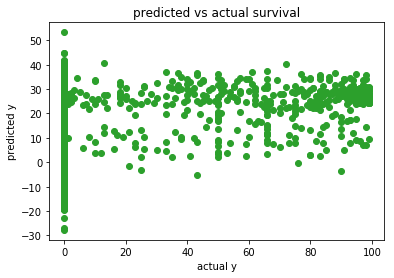

train:  0.375450226375
test:  0.272521252022
train:  0.409025317397
test:  0.0906210977257
train:  0.326132863633
test:  0.371263618695



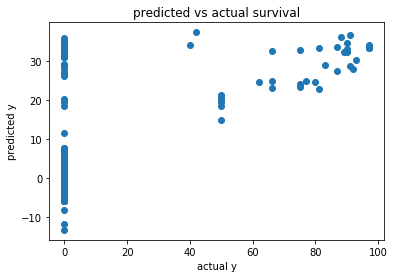

In [183]:
linear(catFrame)
linear(catFrame[catFrame['UNSD Geographical Grouping'] == geoIndex.get_loc('Central America')])

In [184]:
def ohcLinear(dataframe):
    y = np.array((pd.to_numeric(dataframe['Number of survivors']) / dataframe['total people']).fillna(0))
    y = np.nan_to_num(y)
    y[y == np.abs(np.inf)] = 0    
    y = (100*y).astype(int)

    x = np.array(dataframe[['percent female','percent kids', 'percent male', 'month', 'day','x','y','z']])
    x = np.nan_to_num(x)

    x[:,0] = (100*x[:,0]).astype(int)
    x[:,1] = (100*x[:,1]).astype(int)
    x[:,2] = (100*x[:,2]).astype(int)


    rs = ShuffleSplit(n_splits=3, test_size=.25, random_state=0)

    for train_index, test_index in rs.split(x):
        regr = linear_model.LinearRegression()
        regr.fit(x[train_index],y[train_index])
        print("train: ", regr.score(x[train_index],y[train_index]) )
        print("test: ", regr.score(x[test_index],y[test_index]))
    print()
    plt.scatter(y,regr.predict(x))
    plt.xlabel("actual y")
    plt.ylabel('predicted y')
    plt.title('predicted vs actual survival')
    plt.show()

Testing with one hot coding, predicting survival %

C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


train:  0.0938593393261
test:  0.0952305442274
train:  0.0934463600139
test:  0.0963295735941
train:  0.0960931169061
test:  0.0882292992852



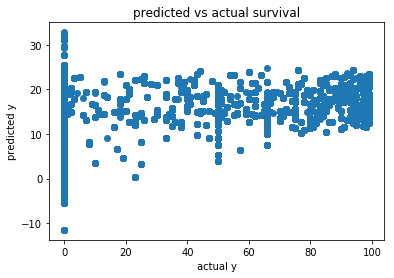

In [185]:
ohcLinear(oneHotCodeFrame)

We also tried SVM to again predict % survived

In [186]:
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [187]:
def suppVector(dataframe):

    y = np.array((pd.to_numeric(dataframe['Number of survivors']) / dataframe['total people']).fillna(0))
    y = np.nan_to_num(y)
    y[y == np.abs(np.inf)] = 0
    y = (100*y).astype(int)

    x = np.array(dataframe[['percent female', 'percent kids', 'percent male', 'day','month','x','y','z']])
    x = np.column_stack((x,np.array(dataframe.loc[:,'UNSD_0':])))
    x = np.nan_to_num(x)
    x[:,0] = (100*x[:,0]).astype(int)
    x[:,1] = (100*x[:,1]).astype(int)
    x[:,2] = (100*x[:,2]).astype(int)

    ntr = len(y)//4 *3
    x_tr = x[:ntr,:]
    y_tr = y[:ntr]
    x_ts = x[ntr:,:]
    y_ts = y[ntr:]
    
    svc = svm.SVC(probability = False, kernel = "rbf", C = 1.0, gamma = 1/ntr, verbose = 10)
    
    print(x_ts.shape,y_ts.shape)
    print(x_tr.shape,y_tr.shape)
    print(ntr)
    svc.fit(x_tr,y_tr)
    
    yhat = svc.predict(x_ts)
    acc = np.mean(yhat == y_ts)
    print('Accuracy = {0:f}'.format(acc))
    
    plt.scatter(y,regr.predict(x))        
    plt.xlabel("actual y")
    plt.ylabel('predicted y')
    plt.title('predicted vs actual survival')
    plt.show()

In [ ]:
def suppVectorCat(dataframe):
    y = np.array((pd.to_numeric(dataframe['Number of survivors']) / dataframe['total people']).fillna(0))
    y = np.nan_to_num(y)
    y[y == np.abs(np.inf)] = 0
    y = (100*y).astype(int)

    x = np.array(dataframe[['UNSD Geographical Grouping', 'Migrant Route', 'Region of Incident', 'percent female',
                     'percent kids', 'percent male', 'month', 'day','x','y','z']])
    x = np.nan_to_num(x)

    x[:,3] = (100*x[:,3]).astype(int)
    x[:,4] = (100*x[:,4]).astype(int)
    x[:,2] = (100*x[:,2]).astype(int)

    ntr = len(y)//4 *3
    x_tr = x[:ntr,:]
    y_tr = y[:ntr]
    x_ts = x[ntr:,:]
    y_ts = y[ntr:]
    
    svc = svm.SVC(probability = False, kernel = "rbf", C = 1.0, gamma = 1/ntr, verbose = 10)
    
    print(x_ts.shape,y_ts.shape)
    print(x_tr.shape,y_tr.shape)
    print(ntr)
    svc.fit(x_tr,y_tr)
    
    yhat = svc.predict(x_ts)
    acc = np.mean(yhat == y_ts)
    print('Accuracy = {0:f}'.format(acc))
    plt.scatter(y,svc.predict(x))
    plt.xlabel("actual y")
    plt.ylabel('predicted y')
    plt.title('predicted vs actual survival')
    plt.show()

In [ ]:
suppVectorCat(catFrame)
# suppVector(oneHotCodeFrame) #this takes forever

C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in multiply
  if sys.path[0] == '':


(802, 11) (802,)
(2397, 11) (2397,)
2397
[LibSVM]

We also tried a neural network to predict both the % that will survive, and just if 50% or more will survive

In [ ]:
import keras
from keras.models import Model,Sequential
from keras.layers import Dense,Activation
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras import optimizers

Predicting the % that will survive

In [ ]:
def nnCat(dataframe):
    y = np.array((pd.to_numeric(dataframe['Number of survivors']) / dataframe['total people']).fillna(0))
    y = np.nan_to_num(y)
    y[y == np.abs(np.inf)] = 0
    
    y = (100*y).astype(int)


    x = np.array(dataframe[['UNSD Geographical Grouping', 'Migrant Route', 'Region of Incident', 'percent female',
                     'percent kids', 'percent male', 'month', 'day']])
    x = np.nan_to_num(x)

    x[:,3] = (100*x[:,3]).astype(int)
    x[:,4] = (100*x[:,4]).astype(int)
    x[:,2] = (100*x[:,2]).astype(int)
    
    ntr = len(y)//4 *3
    x_tr = x[:ntr,:]
    y_tr = y[:ntr]
    x_ts = x[ntr:,:]
    y_ts = y[ntr:]

    K.clear_session()

    nin = x.shape[1]
    nout = int(np.max(y)+1) 
    model = Sequential()
    model.add(Dense(100, input_shape=(nin,), activation='sigmoid', name='hidden'))
    model.add(Dense(nout, activation='softmax', name='output'))

    model.summary()

    opt = optimizers.Adam(lr=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_tr, y_tr, epochs=10, batch_size=100, validation_data=(x_ts,y_ts))

In [ ]:
nnCat(catFrame)

Making a binary decision about survival

In [ ]:
def nn(dataframe):
    y = np.array(pd.to_numeric(dataframe['Number of survivors']) / dataframe['total people'].fillna(0) > .5).astype(int)
    y = np.nan_to_num(y)

    x = np.array(dataframe[['UNSD Geographical Grouping', 'Migrant Route', 'Region of Incident', 'percent female',
                     'percent kids', 'percent male', 'month', 'day']])  #using xyz makes accuracy worse
    x = np.nan_to_num(x)

    x[:,3] = (100*x[:,3]).astype(int)
    x[:,4] = (100*x[:,4]).astype(int)
    x[:,5] = (100*x[:,5]).astype(int)
   
    ntr = len(y)//4 *3
    x_tr = x[:ntr,:]
    y_tr = y[:ntr]
    x_ts = x[ntr:,:]
    y_ts = y[ntr:]

    K.clear_session()

    nin = x.shape[1]
    nout = int(np.max(y)+1) 
    model = Sequential()
    model.add(Dense(100, input_shape=(nin,), activation='sigmoid', name='hidden'))
    model.add(Dense(nout, activation='softmax', name='output'))

    model.summary()

    opt = optimizers.Adam(lr=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_tr, y_tr, epochs=10, batch_size=100, validation_data=(x_ts,y_ts)) 
    
    return model,x_tr,y_tr,x_ts,y_ts

In [ ]:
nnModel,x_tr,y_tr,x_ts,y_ts = nn(catFrame)

We wanted to figure out what features lead to success. We made tests that kept the other features at their average and went through the range of all possible values of one feature. We checked if any of those outputs were one. They wern't.  

In [ ]:
x_avg = np.mean(x,axis=0).astype(int)
geoTest =[]
for i in range(max(catFrame['UNSD Geographical Grouping'])):
    geoTest.append(np.append([i],x_avg[1:]))
geoTest = np.array(geoTest)
geoY = nnModel.predict(geoTest)
geoY

In [ ]:
mrTest =[]
for i in range(max(catFrame['Migrant Route'])):
    mrTest.append(np.append(x_avg[:1],np.append([i],x_avg[2:])))
mrTest = np.array(mrTest)
mrY = nnModel.predict(mrTest)
mrY


In [ ]:
regionTest =[]
for i in range(max(catFrame['Region of Incident'])):
    regionTest.append(np.append(x_avg[:2],np.append([i],x_avg[3:])))
regionTest = np.array(regionTest)
regionY = nnModel.predict(regionTest)
regionY